In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from wordcloud import WordCloud

In [5]:
#Reading the data
dftrain=pd.read_csv("train.csv")
dftrain.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


We have 159570 rows and 8 columns here and the output columns are clear from their names only.

In [7]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [8]:
dftrain.shape

(159571, 8)

In [9]:
# need to create a separate coclumn for comment length
dftrain['comments_length'] = dftrain['comment_text'].str.len()
dftrain.head(10)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comments_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,65
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,115
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,472
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,70


In [10]:
def clean_txt(text):
    text = text.lower() #Converting the text to lower case
    text = re.sub('\[.*?\]','',text) #Replacing email addresses
    text = re.sub('\\W', ' ', text) #Removing Punctuations
    text = re.sub('https?://\S+|www\.S+', '', text)  #Replace URLs with 'webaddress'
    text = re.sub('<.*?>+', '', text) #Removing the HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)#Removing Punctuations
    text = re.sub('\n', '', text) #Removing new lines
    text = re.sub('\w*\d\w*', '', text)
    tokenized_text = word_tokenize(text) #word_tokenization
    stop_words = set(stopwords.words('english') + ['u','ur','im','doin', 'ü', 'â', 'e', 'ur', 'doin', 'ure','READ MORE']) #declaring stop Stop_Words
    WL = WordNetLemmatizer() #declaring lemmatizer
    text = [WL.lemmatize(word) for word in tokenized_text if word not in stop_words if word.isalpha()] # lemmatization and removal of stop_words
    return " " .join(text)

In [11]:
dftrain['comment_text'] = dftrain['comment_text'].apply(clean_txt)
dftrain.head(5)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comments_length
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,aww match background colour seemingly stuck th...,0,0,0,0,0,0,112
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,233
3,0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0,622
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,67


In [12]:
# cleaned length
dftrain['cleaned_com_text'] = dftrain["comment_text"].str.len()
dftrain.head(10)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comments_length,cleaned_com_text
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,264,156
1,000103f0d9cfb60f,aww match background colour seemingly stuck th...,0,0,0,0,0,0,112,67
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,233,141
3,0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0,622,363
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,67,29
5,00025465d4725e87,congratulation well use tool well talk,0,0,0,0,0,0,65,38
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,44,27
7,00031b1e95af7921,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0,115,57
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0,472,277
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0,70,36


In [13]:
final = ['malignant', 'highly_malignant', 'loathe', 'rude', 'abuse', 'threat']
for i in final: 
    print(i)
    print(dftrain[i].value_counts())
    print("\n")

malignant
0    144277
1     15294
Name: malignant, dtype: int64


highly_malignant
0    157976
1      1595
Name: highly_malignant, dtype: int64


loathe
0    158166
1      1405
Name: loathe, dtype: int64


rude
0    151122
1      8449
Name: rude, dtype: int64


abuse
0    151694
1      7877
Name: abuse, dtype: int64


threat
0    159093
1       478
Name: threat, dtype: int64




malignant
0    144277
1     15294
Name: malignant, dtype: int64


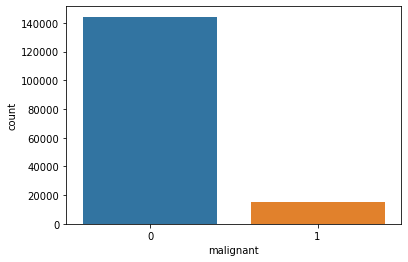



highly_malignant
0    157976
1      1595
Name: highly_malignant, dtype: int64


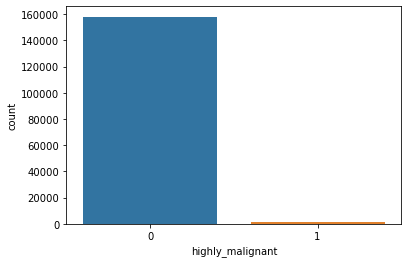



loathe
0    158166
1      1405
Name: loathe, dtype: int64


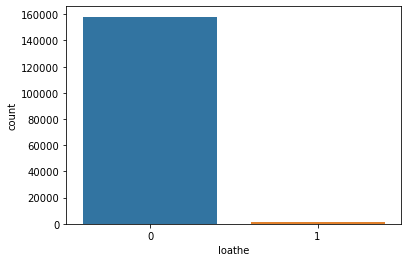



rude
0    151122
1      8449
Name: rude, dtype: int64


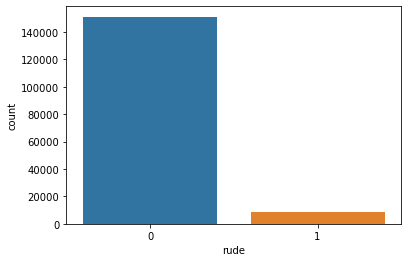



abuse
0    151694
1      7877
Name: abuse, dtype: int64


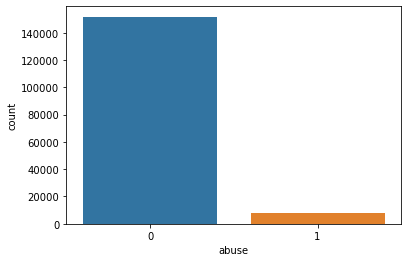



threat
0    159093
1       478
Name: threat, dtype: int64


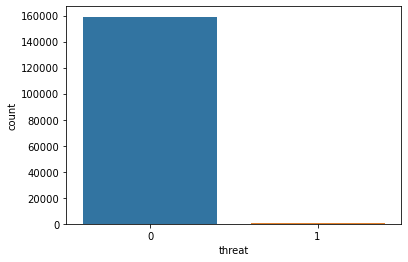

In [14]:
target = ['malignant', 'highly_malignant', 'loathe', 'rude', 'abuse', 'threat']
for i in target: 
    print(i)
    print(dftrain[i].value_counts())
    sns.countplot(dftrain[i])
    plt.show()
    print("\n")

Observations: 
    Malignant: There are 15294 Yes here.
        
    Highly Malignant: There are 1595 Yes's here.
        
    Loath: There are 1405 Yes's here.
    
    Rude: There are 8449 Yes's here. 
        
    Abuse: There are 7877 Yes's here.
        
    Threat: There are 478 Yes's here.

15294


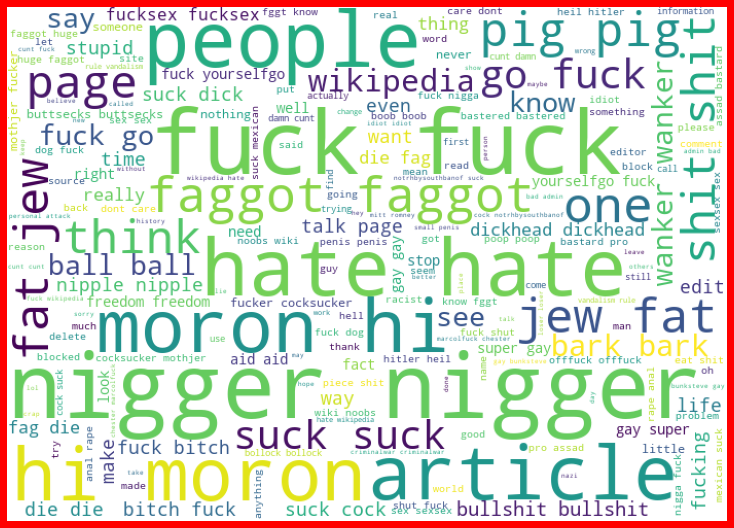

In [15]:
# Getting the details of malignant
plot = dftrain['comment_text'][dftrain['malignant']==1]
print(len(plot))
plot_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(plot))
plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(plot_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

1595


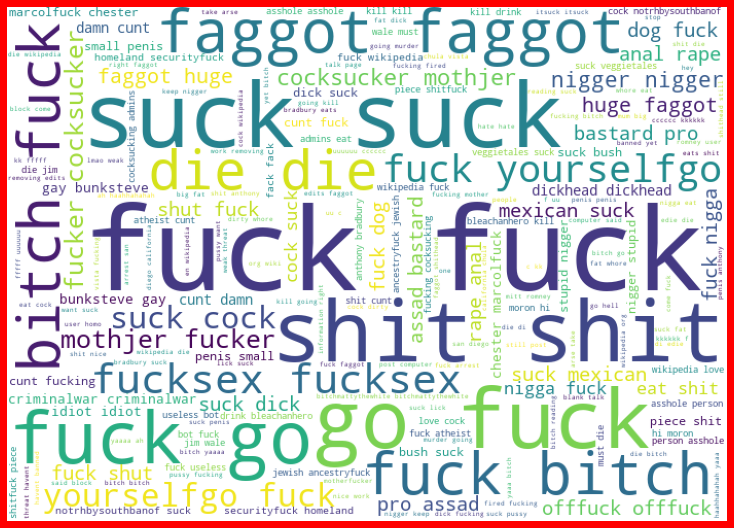

In [16]:
# Getting the details of highly_malignant

plot = dftrain['comment_text'][dftrain['highly_malignant']==1]
print(len(plot))
plot_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(plot))
plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(plot_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

8449


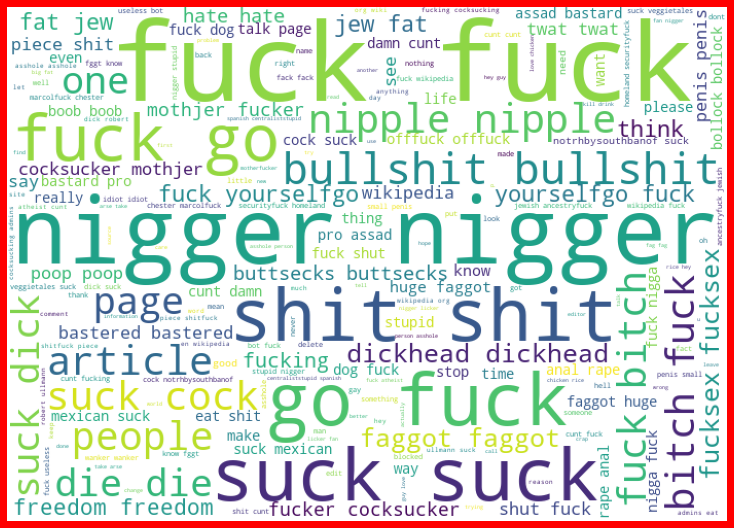

In [17]:
# Getting the details of Rude

plot = dftrain['comment_text'][dftrain['rude']==1]
print(len(plot))
plot_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(plot))
plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(plot_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

478


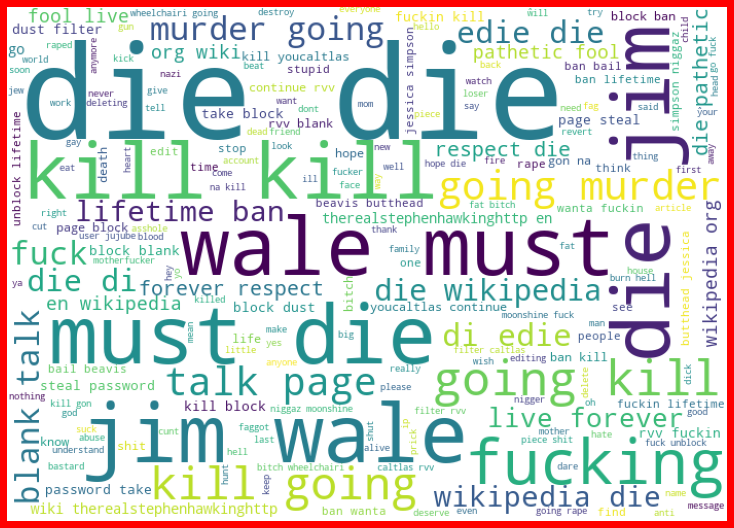

In [18]:
# Getting the details of Threat

plot = dftrain['comment_text'][dftrain['threat']==1]
print(len(plot))
plot_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(plot))
plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(plot_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

7877


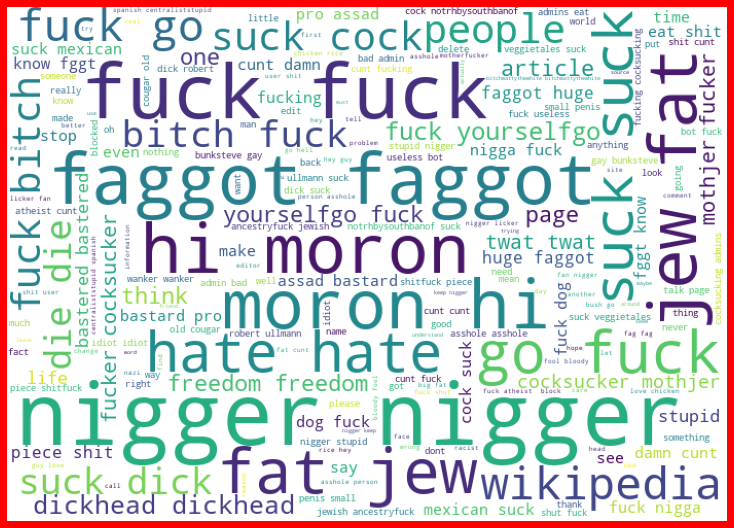

In [19]:
#Getting the details of Abuse

plot = dftrain['comment_text'][dftrain['abuse']==1]
print(len(plot))
plot_cloud = WordCloud(width=700,height=500,background_color='white',max_words=200).generate(' '.join(plot))
plt.figure(figsize=(10,8),facecolor='r')
plt.imshow(plot_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [20]:
dftrain.shape

(159571, 10)

In [21]:
# Adding a target variable which includes all the final info. 
dftrain["Target"] = dftrain[target].sum(axis=1)
dftrain.head(5)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comments_length,cleaned_com_text,Target
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,264,156,0
1,000103f0d9cfb60f,aww match background colour seemingly stuck th...,0,0,0,0,0,0,112,67,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,233,141,0
3,0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0,622,363,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,67,29,0


In [22]:
dftrain["Target"].unique()

array([0, 4, 1, 3, 2, 5, 6], dtype=int64)

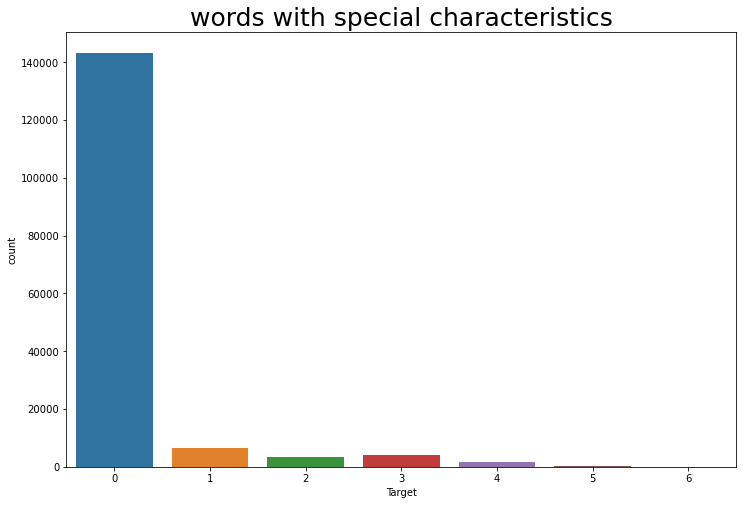

In [23]:
plt.figure(figsize=(12,8))
sns.countplot(dftrain["Target"])
plt.title("words with special characteristics",fontsize=25)
plt.show()

In [24]:
dftrain['Target'] = dftrain['Target'] > 0 
dftrain['Target'] = dftrain['Target'].astype(int)
print(dftrain['Target'].value_counts())

0    143346
1     16225
Name: Target, dtype: int64


In [25]:
dftrain.head(10)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comments_length,cleaned_com_text,Target
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,264,156,0
1,000103f0d9cfb60f,aww match background colour seemingly stuck th...,0,0,0,0,0,0,112,67,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,233,141,0
3,0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0,622,363,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0,67,29,0
5,00025465d4725e87,congratulation well use tool well talk,0,0,0,0,0,0,65,38,0
6,0002bcb3da6cb337,cocksucker piss around work,1,1,1,0,1,0,44,27,1
7,00031b1e95af7921,vandalism matt shirvington article reverted pl...,0,0,0,0,0,0,115,57,0
8,00037261f536c51d,sorry word nonsense offensive anyway intending...,0,0,0,0,0,0,472,277,0
9,00040093b2687caa,alignment subject contrary dulithgow,0,0,0,0,0,0,70,36,0


In [26]:
# Dropping ID cloumns as it do not contrinute anyway to the o/p variable.
dftrain = dftrain.drop(['id'], axis = 1)

In [27]:
dftrain.Target.unique()

array([0, 1])

In [28]:
tfidf = TfidfVectorizer(max_features= 2000)

In [29]:
x = tfidf.fit_transform(dftrain['comment_text'])
y = dftrain[['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']]

In [30]:
# splitting data
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=111,test_size=.30)

In [31]:
x.shape, y.shape

((159571, 2000), (159571, 6))

In [32]:
x_train.shape, y_train.shape

((111699, 2000), (111699, 6))

### MODEL BUILIDING :

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import skmultilearn
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc,f1_score, log_loss
from sklearn.model_selection import GridSearchCV,cross_val_score



In [34]:
# Creating instances
LR = LogisticRegression()
SVC= LinearSVC(random_state=0)
MNB=MultinomialNB()

In [35]:
models= []
models.append(LR)
models.append(MNB)
models.append(SVC)


estimators = []
estimators.append(BinaryRelevance)
estimators.append(ClassifierChain)


In [36]:
Model=[]
Estimator = []
F1_Score = []


for model in models:
    
    for estimator in estimators:
        
        # model fitting
        clf=estimator(model)
        Model.append(model)
        Estimator.append(estimator)
        clf.fit(x_train,y_train)
        clf_pred=clf.predict(x_test)
        #f1_score
        F1Score = f1_score(clf_pred, y_test, average='micro')
        F1_Score.append(F1Score*100)

        

In [37]:
Scores=pd.DataFrame({'Model':Model, 'Estimator': Estimator, 'F1_Score':F1_Score})
Scores

,Model,Estimator,F1_Score
0,LogisticRegression(),<class 'skmultilearn.problem_transform.br.Bina...,68.364642
1,LogisticRegression(),<class 'skmultilearn.problem_transform.cc.Clas...,69.524075
2,MultinomialNB(),<class 'skmultilearn.problem_transform.br.Bina...,61.390917
3,MultinomialNB(),<class 'skmultilearn.problem_transform.cc.Clas...,59.096883
4,LinearSVC(random_state=0),<class 'skmultilearn.problem_transform.br.Bina...,69.642253
5,LinearSVC(random_state=0),<class 'skmultilearn.problem_transform.cc.Clas...,69.846678


In [38]:
clf=ClassifierChain(LinearSVC(random_state=0))
clf.fit(x_train,y_train)
clf_pred=clf.predict(x_test)
acc=accuracy_score(y_test,clf_pred)
ll=log_loss(y_test,clf_pred.toarray())
print({'accuracy':acc,'log_loss':ll})

{'accuracy': 0.9205798796791443, 'log_loss': 1.2464937357517036}


In [39]:
print(classification_report(y_test,clf_pred))

              precision    recall  f1-score   support

           0       0.89      0.62      0.73      4566
           1       0.56      0.19      0.29       467
           2       0.87      0.71      0.78      2529
           3       0.69      0.18      0.28       151
           4       0.74      0.63      0.68      2378
           5       0.65      0.25      0.36       444

   micro avg       0.83      0.60      0.70     10535
   macro avg       0.73      0.43      0.52     10535
weighted avg       0.82      0.60      0.69     10535
 samples avg       0.05      0.05      0.05     10535



### Saving:

In [40]:
import joblib
joblib.dump(clf,'Malignant_comments.pkl')

['Malignant_comments.pkl']

#### Checking for predictions in test data as well:

In [41]:
dftest = pd.read_csv('test.csv')
dftest.head(5)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [42]:
dftest.shape

(153164, 2)

In [43]:
dftest.drop('id',axis=1,inplace=True)
dftest.head(5)

,comment_text
0,Yo bitch Ja Rule is more succesful then you'll...
1,== From RfC == \n\n The title is fine as it is...
2,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,":If you have a look back at the source, the in..."
4,I don't anonymously edit articles at all.


In [44]:
dftest['comment_text'] = dftrain['comment_text'].apply(clean_txt)
dftest.head(5)

,comment_text
0,explanation edits made username hardcore metal...
1,aww match background colour seemingly stuck th...
2,hey man really trying edit war guy constantly ...
3,make real suggestion improvement wondered sect...
4,sir hero chance remember page


In [45]:
xtest = tfidf.fit_transform(dftest['comment_text'])

In [46]:
test_model = joblib.load('Malignant_comments.pkl')

### Test predictions:

In [47]:
df_pred = test_model.predict(xtest)
df_predict = df_pred.toarray()
Malinant_comments_predictions = pd.DataFrame(df_predict)

In [48]:
Malinant_comments_predictions.sample(10)

,0,1,2,3,4,5
36845,0.0,0.0,0.0,0.0,0.0,0.0
70312,0.0,0.0,0.0,0.0,0.0,0.0
66049,0.0,0.0,0.0,0.0,0.0,0.0
114904,0.0,0.0,0.0,0.0,0.0,0.0
3192,0.0,0.0,0.0,0.0,0.0,0.0
263,0.0,0.0,0.0,0.0,0.0,0.0
76614,1.0,0.0,1.0,0.0,1.0,0.0
107183,0.0,0.0,0.0,0.0,0.0,0.0
138455,0.0,0.0,0.0,0.0,0.0,0.0
22184,0.0,0.0,0.0,0.0,0.0,0.0


We are able to see here that Linear SVC with an accuracy of 91.99532085561497% to the given multi-classification data-set.






xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx..................................xxxxxxxxxxxxx..........xxxxxxxxxxxxxxxxxxx